<a href="https://colab.research.google.com/github/Tierprot/Deep-Learning/blob/master/hw2_part2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

#from utils import mnist, plot_graphs
import numpy as np

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [2]:
!ls /content/gdrive/'My Drive'/Colab_Notebooks/utils.py

import sys
sys.path.append('/content/gdrive/My Drive/Colab_Notebooks')
from utils import mnist, plot_graphs 

'/content/gdrive/My Drive/Colab_Notebooks/utils.py'


In [3]:
train_loader, valid_loader, test_loader = mnist(valid=10000)

0it [00:00, ?it/s]

9920512it [00:01, 9477553.24it/s]                            


Extracting ./MNIST_data/MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST_data/MNIST/raw


  0%|          | 0/28881 [00:00<?, ?it/s]

32768it [00:00, 142200.83it/s]           
  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./MNIST_data/MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST_data/MNIST/raw


1654784it [00:00, 2237525.35it/s]                            
  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./MNIST_data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST_data/MNIST/raw


8192it [00:00, 54271.01it/s]            


Extracting ./MNIST_data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST_data/MNIST/raw
Processing...
Done!


In [0]:
class Net(nn.Module):
    def __init__(self, lr=1):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(28*28, 1280)
        self.fc2 = nn.Linear(1280, 1280)
        self.fc3 = nn.Linear(1280, 10)
        self.optim = optim.SGD(self.parameters(), lr=lr)
        
    def forward(self, x):
        x = x.view(-1, 28*28)
        x = torch.sigmoid(self.fc1(x))
        x = torch.sigmoid(self.fc2(x))
        x = self.fc3(x)
        x = torch.log_softmax(x, dim=1)
        return x
    
    def loss(self, output, target, **kwargs):
        self._loss = F.nll_loss(output, target, **kwargs)
        return self._loss

In [0]:
def train(epoch, models):
    train_size = len(train_loader.sampler)
    for batch_idx, (data, target) in enumerate(train_loader):
        for k, model in models.items():
            model.optim.zero_grad()
            output = model(data)
            loss = model.loss(output, target)
            loss.backward()
            model.optim.step()
            
        if batch_idx % 200 == 0:
            line = 'Train Epoch: {} [{}/{} ({:.0f}%)]\tLosses '.format(
                epoch, batch_idx * len(data), train_size, 100. * batch_idx / len(train_loader))
            losses = ' '.join(['{}: {:.6f}'.format(k, m._loss.item()) for k, m in models.items()])
            print(line + losses)
            
    else:
        batch_idx += 1
        line = 'Train Epoch: {} [{}/{} ({:.0f}%)]\tLosses '.format(
            epoch, batch_idx * len(data), train_size, 100. * batch_idx / len(train_loader))
        losses = ' '.join(['{}: {:.6f}'.format(k, m._loss.item()) for k, m in models.items()])
        print(line + losses)

In [0]:
models = {'default': Net()}
train_log = {k: [] for k in models}
test_log = {k: [] for k in models}

In [0]:
def test(models, loader, log=None):
    test_size = len(loader.sampler)
    avg_lambda = lambda l: 'Loss: {:.4f}'.format(l)
    acc_lambda = lambda c, p: 'Accuracy: {}/{} ({:.0f}%)'.format(c, test_size, p)
    line = lambda i, l, c, p: '{}: '.format(i) + avg_lambda(l) + '\t' + acc_lambda(c, p)

    test_loss = {k: 0. for k in models}
    correct = {k: 0. for k in models}
    with torch.no_grad():
        for data, target in loader:
            # output = {k: m(data) for m in models}
            for k, m in models.items():
                output = m(data)
                test_loss[k] += m.loss(output, target, reduction='sum').item() # sum up batch loss
                pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
                correct[k] += pred.eq(target.data.view_as(pred)).cpu().sum().item()
    
    for k in models:
        test_loss[k] /= test_size
    correct_pct = {k: 100. * correct[k] / test_size for k in correct}
    lines = '\n'.join([line(k, test_loss[k], correct[k], correct_pct[k]) for k in models]) + '\n'
    report = 'Test set:\n' + lines
    if log is not None:
        for k in models:
            log[k].append((test_loss[k], correct_pct[k]))
    print(report)

In [8]:
for epoch in range(1, 101):
    for model in models.values():
        model.train()
    train(epoch, models)
    for model in models.values():
        model.eval()
    test(models, valid_loader, test_log)

Train Epoch: 1 [0/50000 (0%)]	Losses default: 2.350373
Train Epoch: 1 [10000/50000 (20%)]	Losses default: 1.543689
Train Epoch: 1 [20000/50000 (40%)]	Losses default: 0.508720
Train Epoch: 1 [30000/50000 (60%)]	Losses default: 0.371755
Train Epoch: 1 [40000/50000 (80%)]	Losses default: 0.558088
Train Epoch: 1 [50000/50000 (100%)]	Losses default: 0.114217
Test set:
default: Loss: 0.2673	Accuracy: 9182.0/10000 (92%)

Train Epoch: 2 [0/50000 (0%)]	Losses default: 0.190381
Train Epoch: 2 [10000/50000 (20%)]	Losses default: 0.141481
Train Epoch: 2 [20000/50000 (40%)]	Losses default: 0.224114
Train Epoch: 2 [30000/50000 (60%)]	Losses default: 0.096323
Train Epoch: 2 [40000/50000 (80%)]	Losses default: 0.226953
Train Epoch: 2 [50000/50000 (100%)]	Losses default: 0.048510
Test set:
default: Loss: 0.1743	Accuracy: 9460.0/10000 (95%)

Train Epoch: 3 [0/50000 (0%)]	Losses default: 0.085231
Train Epoch: 3 [10000/50000 (20%)]	Losses default: 0.234838
Train Epoch: 3 [20000/50000 (40%)]	Losses default

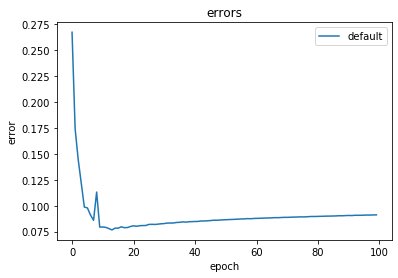

In [9]:
plot_graphs(test_log, 'loss')

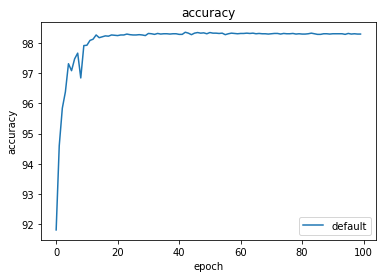

In [10]:
plot_graphs(test_log, 'accuracy')